In [1]:
import numpy as np
import wandb

import os
import shutil

import torch
import scipy
import numpy as np

import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import tabulate

import itertools

from matplotlib import rc

rc('text', usetex=True)
rc('font',**{'family':'serif','serif':['Computer Modern Roman']})

%matplotlib inline
palette = sns.color_palette()

api = wandb.Api()

**Note:** this notebook uses outdated experiment config names; you may need to change experiment name regexps to run this code.

In [2]:
def query_runs(api, exp_name_regex, step):    
    runs = api.runs(
        'timgaripov/support_alignment_v2', # Use your wandb project name heere
        filters={
            '$and': [
                {'config.experiment_name': {'$regex': exp_name_regex}},
                {'state': 'finished'},
                {'summary_metrics.step': {'$eq': step}},
            ]
        },
        order='config.config/training/seed.value'
    )
    return runs


In [3]:
class ResultsTable(object):
    def mean_std_fn(vals):    
        mean = np.mean(vals)
        std = np.std(vals)
        return f'{mean:.2f} ({std:.2f}) [{len(vals)}]'
    def median_iqr_fn(vals):    
        median = np.median(vals)
        iqr = scipy.stats.iqr(vals)
        return f'{median:.2f} ({iqr:.2f}) [{len(vals)}]'
    def quant_fn(vals):    
        quants = np.quantile(vals, np.array([0.25, 0.5, 0.75]))
        return f'{quants[0]:05.2f} {quants[1]:05.2f} {quants[2]:05.2f} [{len(vals)}]'
    
    def quant_latex_fn(vals):    
        quants = np.quantile(vals, np.array([0.25, 0.5, 0.75]))
        return f'$ {quants[1]:04.1f}_{{~{quants[0]:04.1f}}}^{{~{quants[2]:04.1f}}} $'
    
    def median_x_fn(vals):    
        median = np.median(vals)        
        return f'{median:.4f} [{len(vals)}]'
    
    def median_x_fn(vals):    
        median = np.median(vals)
        iqr = scipy.stats.iqr(vals)
        return f'{median:.4f} [{len(vals)}]'
    
    def quant_latex_x_fn(vals):    
        quants = np.quantile(vals, np.array([0.25, 0.5, 0.75]))
        return f'$ {quants[1]:05.2f}_{{~{quants[0]:05.2f}}}^{{~{quants[2]:05.2f}}} $'
    
    def __init__(self, prefix, algorithms, imbalance_levels, num_steps):
        api = wandb.Api()
        
        self.prefix = prefix
        self.imbalance_levels = imbalance_levels
        self.algorithms = algorithms
        
        
        self.summaries = [
            'eval/target_val/accuracy_class_avg',
            'eval/target_val/accuracy_class_min',
            'eval/target_val/ce_class_avg',            
            'alignment_eval_original/ot_sq',
            'alignment_eval_original/supp_dist_sq',            
            'alignment_eval_original/log_loss',
        ]
        
        self.results = {
            summary_name: list() for summary_name in self.summaries
        }
        for algorithm_name in algorithms:
            for summary_name in self.summaries:
                self.results[summary_name].append([])
            for imbalance_level in imbalance_levels:
                regex = f'{prefix}/seed_[1-5]/s_alpha_{imbalance_level}/{algorithm_name}[^0_]'
                print(regex)
                runs = query_runs(api, regex, step=num_steps)
                print(f'Runs: {len(runs)}')
                for summary_name in self.summaries:                    
                    self.results[summary_name][-1].append([run.summary.get(summary_name, -1.0) for run in runs])                                                
                
            print()
        
    def print_table(self, summaries, agg_fn, tablefmt='pipe', sep=' '):
        print(f'{self.prefix} {" ".join(summaries)}')
        columns = ['algorithm'] + self.imbalance_levels
        table = [columns]
        for i, algorithm_name in enumerate(self.algorithms):
            table.append([algorithm_name])
            for j, imbalance_level in enumerate(self.imbalance_levels):
                cell = ''
                for k, summary_name in enumerate(summaries):
                    values = self.results[summary_name][i][j]                
                    if len(values) > 0:
                        cell += agg_fn(np.array(values))
                    if k + 1 < len(summaries):
                        cell += sep
                table[-1].append(cell)
        print(tabulate.tabulate(table, tablefmt=tablefmt, headers="firstrow"))
        

# USPS->MNIST main results

In [4]:
prefix = '0_usps_mnist/test_lenet_v3' # change to usps_mnist/lenet
imbalance_levels = ['00', '10', '15', '20']
algorithms = [
    'dann_zero',
    'dann',    
    'vada',
    'iwdan_5000', # change to iwdan
    'iwcdan_5000', # change to iwcdan
    'sdann_4',             
    'support_sq',
    'support_abs',    
]

results = ResultsTable(prefix, algorithms, imbalance_levels, num_steps=65000)

0_usps_mnist/test_lenet_v3/seed_[1-5]/s_alpha_00/dann_zero[^0_]
Runs: 5
0_usps_mnist/test_lenet_v3/seed_[1-5]/s_alpha_10/dann_zero[^0_]
Runs: 5
0_usps_mnist/test_lenet_v3/seed_[1-5]/s_alpha_15/dann_zero[^0_]
Runs: 5
0_usps_mnist/test_lenet_v3/seed_[1-5]/s_alpha_20/dann_zero[^0_]
Runs: 5

0_usps_mnist/test_lenet_v3/seed_[1-5]/s_alpha_00/dann[^0_]
Runs: 5
0_usps_mnist/test_lenet_v3/seed_[1-5]/s_alpha_10/dann[^0_]
Runs: 5
0_usps_mnist/test_lenet_v3/seed_[1-5]/s_alpha_15/dann[^0_]
Runs: 5
0_usps_mnist/test_lenet_v3/seed_[1-5]/s_alpha_20/dann[^0_]
Runs: 5

0_usps_mnist/test_lenet_v3/seed_[1-5]/s_alpha_00/vada[^0_]
Runs: 5
0_usps_mnist/test_lenet_v3/seed_[1-5]/s_alpha_10/vada[^0_]
Runs: 5
0_usps_mnist/test_lenet_v3/seed_[1-5]/s_alpha_15/vada[^0_]
Runs: 5
0_usps_mnist/test_lenet_v3/seed_[1-5]/s_alpha_20/vada[^0_]
Runs: 5

0_usps_mnist/test_lenet_v3/seed_[1-5]/s_alpha_00/iwdan_5000[^0_]
Runs: 5
0_usps_mnist/test_lenet_v3/seed_[1-5]/s_alpha_10/iwdan_5000[^0_]
Runs: 5
0_usps_mnist/test_lenet_v3/

In [5]:
results.print_table(['eval/target_val/accuracy_class_avg'], ResultsTable.mean_std_fn)

0_usps_mnist/test_lenet_v3 eval/target_val/accuracy_class_avg
| algorithm   | 00               | 10               | 15               | 20               |
|:------------|:-----------------|:-----------------|:-----------------|:-----------------|
| dann_zero   | 71.09 (2.05) [5] | 72.95 (2.49) [5] | 71.80 (1.04) [5] | 71.75 (1.46) [5] |
| dann        | 97.70 (0.12) [5] | 80.95 (4.84) [5] | 68.65 (6.85) [5] | 58.25 (6.37) [5] |
| vada        | 97.96 (0.10) [5] | 88.79 (1.10) [5] | 76.89 (6.31) [5] | 61.72 (7.35) [5] |
| iwdan_5000  | 97.45 (0.12) [5] | 94.54 (1.95) [5] | 83.78 (5.03) [5] | 74.37 (3.98) [5] |
| iwcdan_5000 | 97.96 (0.17) [5] | 95.44 (2.31) [5] | 89.94 (5.14) [5] | 79.04 (4.13) [5] |
| sdann_4     | 90.63 (4.18) [5] | 93.03 (3.90) [5] | 87.15 (1.81) [5] | 82.35 (2.49) [5] |
| support_sq  | 93.61 (0.36) [5] | 92.48 (1.00) [5] | 90.38 (1.90) [5] | 87.41 (1.72) [5] |
| support_abs | 94.06 (0.50) [5] | 91.27 (2.56) [5] | 91.74 (1.83) [5] | 89.36 (2.49) [5] |


In [6]:
results.print_table(['eval/target_val/accuracy_class_avg'], ResultsTable.quant_fn)

0_usps_mnist/test_lenet_v3 eval/target_val/accuracy_class_avg
| algorithm   | 00                    | 10                    | 15                    | 20                    |
|:------------|:----------------------|:----------------------|:----------------------|:----------------------|
| dann_zero   | 70.44 71.93 72.85 [5] | 72.05 72.91 74.70 [5] | 71.25 71.28 72.51 [5] | 70.58 71.34 72.99 [5] |
| dann        | 97.62 97.77 97.78 [5] | 76.72 83.50 84.55 [5] | 63.89 69.96 71.25 [5] | 52.01 57.77 60.40 [5] |
| vada        | 97.87 97.99 98.00 [5] | 88.07 88.22 89.87 [5] | 70.72 78.19 83.06 [5] | 56.27 61.86 65.38 [5] |
| iwdan_5000  | 97.43 97.52 97.52 [5] | 92.64 95.71 95.78 [5] | 80.23 86.47 87.75 [5] | 70.01 74.40 78.57 [5] |
| iwcdan_5000 | 97.88 97.98 98.07 [5] | 93.33 96.67 97.53 [5] | 90.46 91.32 93.84 [5] | 77.25 77.49 82.31 [5] |
| sdann_4     | 87.20 87.39 95.68 [5] | 94.72 94.90 94.93 [5] | 85.54 86.80 89.06 [5] | 81.29 81.53 83.06 [5] |
| support_sq  | 93.31 93.66 93.87 [5] | 91

In [7]:
results.print_table(['eval/target_val/accuracy_class_min'], ResultsTable.mean_std_fn)

0_usps_mnist/test_lenet_v3 eval/target_val/accuracy_class_min
| algorithm   | 00                | 10                | 15                | 20                |
|:------------|:------------------|:------------------|:------------------|:------------------|
| dann_zero   | 19.52 (4.51) [5]  | 24.96 (9.66) [5]  | 29.22 (7.94) [5]  | 18.70 (7.89) [5]  |
| dann        | 96.06 (0.51) [5]  | 22.30 (14.09) [5] | 6.19 (10.07) [5]  | 1.08 (0.63) [5]   |
| vada        | 96.14 (0.25) [5]  | 48.82 (3.62) [5]  | 12.37 (11.59) [5] | 1.38 (0.87) [5]   |
| iwdan_5000  | 95.75 (0.19) [5]  | 73.42 (16.40) [5] | 27.91 (26.17) [5] | 17.12 (16.02) [5] |
| iwcdan_5000 | 96.59 (0.42) [5]  | 76.47 (20.07) [5] | 58.19 (30.08) [5] | 24.90 (21.45) [5] |
| sdann_4     | 40.00 (42.19) [5] | 71.88 (31.68) [5] | 35.32 (23.36) [5] | 41.11 (16.72) [5] |
| support_sq  | 88.26 (2.89) [5]  | 83.44 (5.52) [5]  | 68.96 (15.43) [5] | 58.03 (12.58) [5] |
| support_abs | 88.68 (2.66) [5]  | 69.69 (20.05) [5] | 74.95 (15.40) [5] 

In [8]:
results.print_table(['eval/target_val/accuracy_class_min'], ResultsTable.quant_fn)

0_usps_mnist/test_lenet_v3 eval/target_val/accuracy_class_min
| algorithm   | 00                    | 10                    | 15                    | 20                    |
|:------------|:----------------------|:----------------------|:----------------------|:----------------------|
| dann_zero   | 17.62 20.28 22.89 [5] | 18.33 25.85 31.82 [5] | 24.21 27.46 37.26 [5] | 10.83 16.55 26.77 [5] |
| dann        | 95.83 96.03 96.12 [5] | 08.38 25.07 36.93 [5] | 00.99 01.11 01.53 [5] | 00.48 00.93 01.63 [5] |
| vada        | 95.87 96.22 96.32 [5] | 47.76 48.91 50.00 [5] | 02.44 06.56 23.46 [5] | 00.83 01.36 01.54 [5] |
| iwdan_5000  | 95.65 95.66 95.88 [5] | 67.12 81.33 82.34 [5] | 04.15 15.19 55.05 [5] | 06.31 07.32 22.36 [5] |
| iwcdan_5000 | 96.36 96.64 96.90 [5] | 65.35 85.10 93.85 [5] | 64.07 66.49 74.50 [5] | 02.68 22.24 45.39 [5] |
| sdann_4     | 05.58 05.63 90.01 [5] | 84.36 85.70 87.69 [5] | 15.38 21.59 50.27 [5] | 37.92 39.34 56.24 [5] |
| support_sq  | 88.43 89.24 89.39 [5] | 80

In [9]:
results.print_table(['eval/target_val/accuracy_class_avg', 'eval/target_val/accuracy_class_min'], 
                    ResultsTable.quant_latex_fn, tablefmt='latex_raw', sep=' & ')

0_usps_mnist/test_lenet_v3 eval/target_val/accuracy_class_avg eval/target_val/accuracy_class_min
\begin{tabular}{lllll}
\hline
 algorithm   & 00                                                  & 10                                                  & 15                                                  & 20                                                  \\
\hline
 dann_zero   & $ 71.9_{~70.4}^{~72.9} $ & $ 20.3_{~17.6}^{~22.9} $ & $ 72.9_{~72.0}^{~74.7} $ & $ 25.8_{~18.3}^{~31.8} $ & $ 71.3_{~71.2}^{~72.5} $ & $ 27.5_{~24.2}^{~37.3} $ & $ 71.3_{~70.6}^{~73.0} $ & $ 16.6_{~10.8}^{~26.8} $ \\
 dann        & $ 97.8_{~97.6}^{~97.8} $ & $ 96.0_{~95.8}^{~96.1} $ & $ 83.5_{~76.7}^{~84.6} $ & $ 25.1_{~08.4}^{~36.9} $ & $ 70.0_{~63.9}^{~71.2} $ & $ 01.1_{~01.0}^{~01.5} $ & $ 57.8_{~52.0}^{~60.4} $ & $ 00.9_{~00.5}^{~01.6} $ \\
 vada        & $ 98.0_{~97.9}^{~98.0} $ & $ 96.2_{~95.9}^{~96.3} $ & $ 88.2_{~88.1}^{~89.9} $ & $ 48.9_{~47.8}^{~50.0} $ & $ 78.2_{~70.7}^{~83.1} $ & $ 06.6_{~02.4}^{~23.

# USPS->MNIST history size ablation

In [10]:
api = wandb.Api()

prefix = '0_usps_mnist/test_lenet_v3' # change to usps_mnist/lenet
imbalance_levels = ['15']
algorithms = [
    'dann_zero',
    'dann',    
    'support_abs_h0',
    'support_abs_h100',
    'support_abs_h500',
    'support_abs',    
    'support_abs_h5000'
]

results_table = [
    ['algorithm', 'avg acc', 'min acc', 'supp_sq', 'ot_sq', 'disc log loss', 'disc range'],
]


for algorithm_name in algorithms:
    results_table.append([algorithm_name])
    for imbalance_level in imbalance_levels:            
        regex = f'{prefix}/seed_[1-5]/s_alpha_{imbalance_level}/{algorithm_name}[^0_]'                
        print(regex)
        runs = query_runs(api, regex, step=65000)
        print(f'Runs: {len(runs)}')        
        
        if not runs:                
            avg_acc_table[-1].append('')
            min_acc_table[-1].append('')
            continue
                        
        seeds = set([run.config['config/training/seed'] for run in runs])        
        
        avg_acc_vals = [run.summary['eval/target_val/accuracy_class_avg'] for run in runs]
        min_acc_vals = [run.summary['eval/target_val/accuracy_class_min'] for run in runs]
        
        avg_acc_mean = np.mean(avg_acc_vals)
        avg_acc_std = np.std(avg_acc_vals)
        
        min_acc_mean = np.mean(min_acc_vals)
        min_acc_std = np.std(min_acc_vals)
        
        results_table[-1].append(f'{avg_acc_mean:05.2f} ({avg_acc_std:.2f}) [{len(runs)}]')
        results_table[-1].append(f'{min_acc_mean:05.2f} ({min_acc_std:.2f}) [{len(runs)}]')
        
        disc_log_loss_vals = [run.summary['alignment_eval_original/log_loss'] for run in runs]
        supp_sq_vals = [run.summary['alignment_eval_original/supp_dist_sq'] for run in runs]
        ot_sq_vals = [run.summary['alignment_eval_original/ot_sq'] for run in runs]
        disc_range_valse = [run.summary['alignment_eval_original/range'] for run in runs]
                      
        disc_log_loss_mean = np.mean(disc_log_loss_vals)
        disc_log_loss_std = np.std(disc_log_loss_vals)
                      
        supp_sq_mean = np.mean(supp_sq_vals)
        supp_sq_std = np.std(supp_sq_vals)
                      
        ot_sq_mean = np.mean(ot_sq_vals)
        ot_sq_std = np.std(ot_sq_vals)
        
        disc_range_mean = np.mean(disc_range_valse)
        disc_range_std = np.std(disc_range_valse)
                              
                      
        results_table[-1].append(f'{supp_sq_mean:.2f} ({supp_sq_std:.2f})')
        results_table[-1].append(f'{ot_sq_mean:.2f} ({ot_sq_std:.2f})')
        results_table[-1].append(f'{disc_log_loss_mean:.2f} ({disc_log_loss_std:.2f})')        
     

0_usps_mnist/test_lenet_v3/seed_[1-5]/s_alpha_15/dann_zero[^0_]
Runs: 5
0_usps_mnist/test_lenet_v3/seed_[1-5]/s_alpha_15/dann[^0_]
Runs: 5
0_usps_mnist/test_lenet_v3/seed_[1-5]/s_alpha_15/support_abs_h0[^0_]
Runs: 5
0_usps_mnist/test_lenet_v3/seed_[1-5]/s_alpha_15/support_abs_h100[^0_]
Runs: 5
0_usps_mnist/test_lenet_v3/seed_[1-5]/s_alpha_15/support_abs_h500[^0_]
Runs: 5
0_usps_mnist/test_lenet_v3/seed_[1-5]/s_alpha_15/support_abs[^0_]
Runs: 5
0_usps_mnist/test_lenet_v3/seed_[1-5]/s_alpha_15/support_abs_h5000[^0_]
Runs: 5


In [11]:
print(prefix)
print(tabulate.tabulate(results_table, tablefmt='pipe', headers="firstrow"))

0_usps_mnist/test_lenet_v3
| algorithm         | avg acc          | min acc           | supp_sq       | ot_sq          | disc log loss   |
|:------------------|:-----------------|:------------------|:--------------|:---------------|:----------------|
| dann_zero         | 71.80 (1.04) [5] | 29.22 (7.94) [5]  | 41.10 (14.57) | 299.71 (34.21) | 0.05 (0.02)     |
| dann              | 68.65 (6.85) [5] | 06.19 (10.07) [5] | 0.00 (0.00)   | 0.11 (0.01)    | 0.65 (0.00)     |
| support_abs_h0    | 63.33 (1.86) [5] | 21.15 (6.30) [5]  | 0.01 (0.00)   | 1.11 (0.17)    | 0.57 (0.01)     |
| support_abs_h100  | 79.68 (2.66) [5] | 39.78 (9.23) [5]  | 0.00 (0.00)   | 2.47 (0.27)    | 0.53 (0.01)     |
| support_abs_h500  | 91.56 (1.94) [5] | 78.20 (8.03) [5]  | 0.00 (0.00)   | 6.54 (1.36)    | 0.45 (0.00)     |
| support_abs       | 91.74 (1.83) [5] | 74.95 (15.40) [5] | 0.01 (0.01)   | 8.11 (0.37)    | 0.41 (0.01)     |
| support_abs_h5000 | 86.04 (1.35) [5] | 57.48 (14.55) [5] | 0.07 (0.03)   | 

In [12]:
prefix = '0_usps_mnist/test_lenet_v3' # change to usps_mnist/lenet
imbalance_levels = ['15']
algorithms = [
    'dann_zero',
    'dann',    
    'support_abs_h0',
    'support_abs_h100',
    'support_abs_h500',
    'support_abs',    
    'support_abs_h2000',
    'support_abs_h5000'
]


results = ResultsTable(prefix, algorithms, imbalance_levels, num_steps=65000)

0_usps_mnist/test_lenet_v3/seed_[1-5]/s_alpha_15/dann_zero[^0_]
Runs: 5

0_usps_mnist/test_lenet_v3/seed_[1-5]/s_alpha_15/dann[^0_]
Runs: 5

0_usps_mnist/test_lenet_v3/seed_[1-5]/s_alpha_15/support_abs_h0[^0_]
Runs: 5

0_usps_mnist/test_lenet_v3/seed_[1-5]/s_alpha_15/support_abs_h100[^0_]
Runs: 5

0_usps_mnist/test_lenet_v3/seed_[1-5]/s_alpha_15/support_abs_h500[^0_]
Runs: 5

0_usps_mnist/test_lenet_v3/seed_[1-5]/s_alpha_15/support_abs[^0_]
Runs: 5

0_usps_mnist/test_lenet_v3/seed_[1-5]/s_alpha_15/support_abs_h2000[^0_]
Runs: 5

0_usps_mnist/test_lenet_v3/seed_[1-5]/s_alpha_15/support_abs_h5000[^0_]
Runs: 5



In [13]:
results.print_table(['eval/target_val/accuracy_class_avg', 'eval/target_val/accuracy_class_min',
                     'alignment_eval_original/ot_sq', 'alignment_eval_original/supp_dist_sq',            
                     'alignment_eval_original/log_loss'], 
                    ResultsTable.median_x_fn, tablefmt='pipe', sep=' & ')

0_usps_mnist/test_lenet_v3 eval/target_val/accuracy_class_avg eval/target_val/accuracy_class_min alignment_eval_original/ot_sq alignment_eval_original/supp_dist_sq alignment_eval_original/log_loss
| algorithm         | 15                                                                  |
|:------------------|:--------------------------------------------------------------------|
| dann_zero         | 71.2800 [5] & 27.4621 [5] & 307.5606 [5] & 40.3524 [5] & 0.0526 [5] |
| dann              | 69.9638 [5] & 1.1070 [5] & 0.1099 [5] & 0.0005 [5] & 0.6519 [5]     |
| support_abs_h0    | 62.7497 [5] & 19.3617 [5] & 1.0688 [5] & 0.0052 [5] & 0.5670 [5]    |
| support_abs_h100  | 80.5766 [5] & 35.0943 [5] & 2.6446 [5] & 0.0019 [5] & 0.5262 [5]    |
| support_abs_h500  | 92.0177 [5] & 76.9554 [5] & 6.2123 [5] & 0.0047 [5] & 0.4476 [5]    |
| support_abs       | 92.5434 [5] & 82.4142 [5] & 8.0561 [5] & 0.0149 [5] & 0.4117 [5]    |
| support_abs_h2000 | 92.2964 [5] & 85.1135 [5] & 12.4314 [5] & 0.0

In [14]:
results.print_table(['eval/target_val/accuracy_class_avg', 'eval/target_val/accuracy_class_min',
                     'alignment_eval_original/ot_sq', 'alignment_eval_original/supp_dist_sq',            
                     'alignment_eval_original/log_loss'], 
                    ResultsTable.quant_latex_x_fn, tablefmt='latex_raw', sep=' & ')

0_usps_mnist/test_lenet_v3 eval/target_val/accuracy_class_avg eval/target_val/accuracy_class_min alignment_eval_original/ot_sq alignment_eval_original/supp_dist_sq alignment_eval_original/log_loss
\begin{tabular}{ll}
\hline
 algorithm         & 15                                                                                                                                                     \\
\hline
 dann_zero         & $ 71.28_{~71.25}^{~72.51} $ & $ 27.46_{~24.21}^{~37.26} $ & $ 307.56_{~277.33}^{~322.00} $ & $ 40.35_{~32.10}^{~46.06} $ & $ 00.05_{~00.04}^{~00.07} $ \\
 dann              & $ 69.96_{~63.89}^{~71.25} $ & $ 01.11_{~00.99}^{~01.53} $ & $ 00.11_{~00.10}^{~00.11} $ & $ 00.00_{~00.00}^{~00.00} $ & $ 00.65_{~00.65}^{~00.65} $    \\
 support_abs_h0    & $ 62.75_{~61.78}^{~64.35} $ & $ 19.36_{~17.90}^{~23.63} $ & $ 01.07_{~00.99}^{~01.15} $ & $ 00.01_{~00.00}^{~00.01} $ & $ 00.57_{~00.56}^{~00.58} $    \\
 support_abs_h100  & $ 80.58_{~78.22}^{~81.73} $ & $ 35.09_{~32.10}^{

findfont: Font family ['serif'] not found. Falling back to DejaVu Sans.


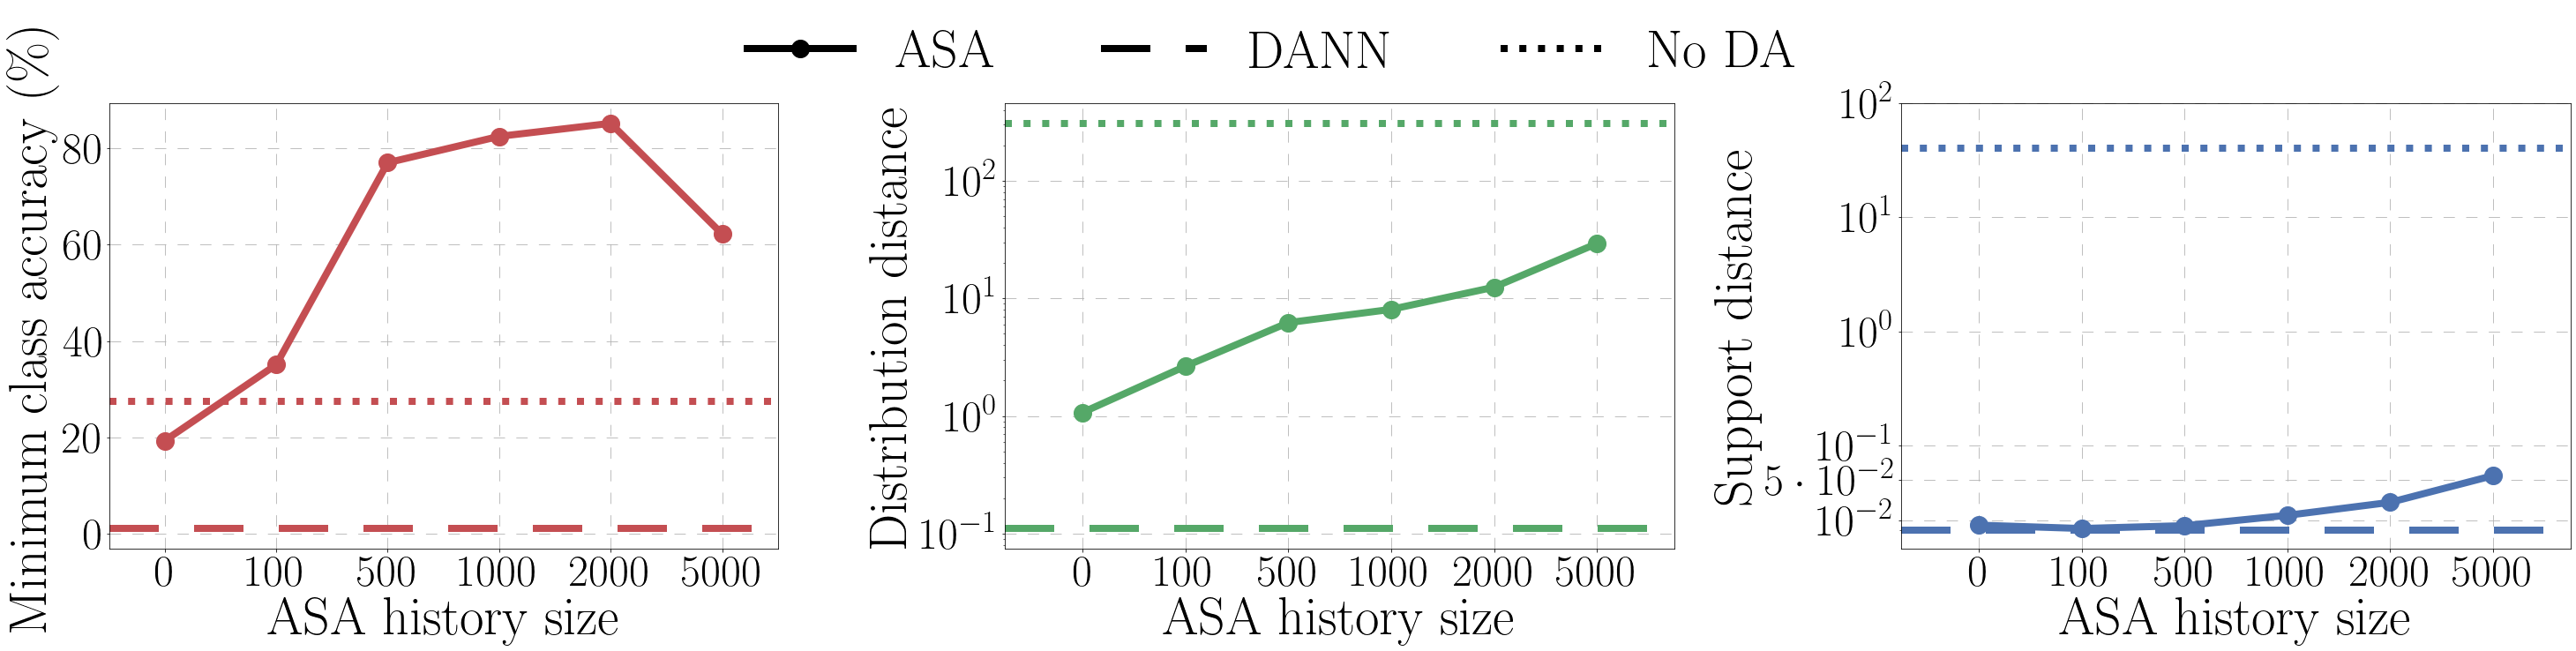

In [15]:
hpalette = sns.color_palette('deep')

h_points = np.array([0, 100, 500, 1000, 2000, 5000])
x_points = np.arange(h_points.size)

min_acc = np.array([19.3617, 35.0943, 76.9554, 82.4142, 85.1135, 62.1928])
avg_acc = np.array([62.7497, 80.5766, 92.0177, 92.5434, 92.2964, 86.0340])
min_err = 100.0 - min_acc
avg_err = 100.0 - avg_acc
dist_sq = np.array([1.0688, 2.6446, 6.2123, 8.0561, 12.4314, 29.2264])
supp_sq = np.array([0.0052, 0.0019, 0.0047, 0.0149, 0.0277, 0.0543])

dann_avg_acc = 69.9638
dann_min_acc = 1.1070
dann_dist_sq = 0.1099
dann_supp_sq = 0.0005

noda_avg_acc = 71.2800
noda_min_acc =  27.4621
noda_dist_sq = 307.5606
noda_supp_sq = 40.3524

fig, axes = plt.subplots(figsize=(50, 9.3), nrows=1, ncols=3)


plt.sca(axes[0])


c_min = hpalette[3]
plt.axhline(y=dann_min_acc, c=c_min, linewidth=8, linestyle='--', dashes=(7, 5))
plt.axhline(y=noda_min_acc, c=c_min, linewidth=8, linestyle='dotted')
plt.plot(x_points, min_acc, c=c_min, linewidth=8, marker='o', markersize=20)


plt.xticks(x_points, h_points, fontsize=50)
plt.yticks(fontsize=50)
plt.margins(x=0.1)
plt.grid(linestyle='--', dashes=(16, 16))  
plt.xlabel('ASA history size', fontsize=60)
plt.ylabel('Minimum class accuracy (\%)', fontsize=60)

legend_elements = [
    matplotlib.lines.Line2D([0], [0], c='k', linewidth=8, marker='o', markersize=20, label='ASA'),
    matplotlib.lines.Line2D([0], [0], c='k', linewidth=8, linestyle='--', dashes=(7, 5), label='DANN'),
    matplotlib.lines.Line2D([0], [0], c='k', linewidth=8, linestyle='dotted', label='No DA'),
]

plt.legend(handles=legend_elements, fontsize=60, ncol=3, 
           loc='lower center', bbox_to_anchor=(1.74, 0.95), frameon=False)


plt.sca(axes[1])


c_dist = hpalette[2]

plt.yscale('log')
plt.axhline(y=dann_dist_sq, c=c_dist, linewidth=8, linestyle='--', dashes=(7, 5))
plt.axhline(y=noda_dist_sq, c=c_dist, linewidth=8, linestyle='dotted')
plt.plot(x_points, dist_sq, c=c_dist, linewidth=8, marker='o', markersize=20)
plt.xticks(x_points, h_points, fontsize=50)
plt.yticks(fontsize=50)
plt.margins(x=0.15)
plt.grid(linestyle='--', dashes=(16, 16)) 
plt.xlabel('ASA history size', fontsize=60)
plt.ylabel('Distribution distance', fontsize=60)


plt.sca(axes[2])
c_supp = hpalette[0]

plt.yscale('symlog', linthreshy=0.05, linscaley=0.4)
plt.axhline(y=dann_supp_sq, c=c_supp, linewidth=8, linestyle='--', dashes=(7, 5))
plt.axhline(y=noda_supp_sq, c=c_supp, linewidth=8, linestyle='dotted')
plt.plot(x_points, supp_sq, c=c_supp, linewidth=8, marker='o', markersize=20)



plt.xticks(x_points, h_points, fontsize=50)

tlabels = ['$10^{-2}$', '$5\cdot 10^{-2}$', '$10^{-1}$', '$10^0$', '$10^1$', '$10^2$']
plt.yticks([10**(-2.0), 5 * 10**(-2.0), 10**(-1.0), 10**(0.0), 10**(1.0), 10 ** (2.0)], tlabels, fontsize=50)
plt.margins(x=0.15)
plt.grid(linestyle='--', dashes=(16, 16)) 
plt.xlabel('ASA history size', fontsize=60)
plt.ylabel('Support distance', fontsize=60)

plt.subplots_adjust(wspace=0.34)
plt.savefig(f'./figures/history_alignment.pdf', format='pdf', bbox_inches='tight')

plt.show()

# Discriminator histogram plot

In [16]:
algorithms = [
    'dann_zero',
    'dann',    
    'support_abs_h0',
    'support_abs',    
]


regex_list = [f'0_usps_mnist/test_lenet_v3/seed_1/s_alpha_15/{algorithm_name}[^0_]' for algorithm_name in algorithms]
runs = [list(query_runs(api, regex, step=65000)) for regex in regex_list]
assert min([len(x) for x in runs]) == 1
assert max([len(x) for x in runs]) == 1
runs = [x[0] for x in runs]

os.makedirs('./data_disc_hist', exist_ok=True)

for run, algorithm_name in zip(runs, algorithms):
    run.file('alignment_eval_outputs.pt').download('./data_disc_hist', replace=True)
    shutil.move('./data_disc_hist/alignment_eval_outputs.pt', f'./data_disc_hist/{algorithm_name}.pt')

In [17]:
def alignment_histplot(src_tensor, trg_tensor, title=None, legend=True, ylabel=True):

    src_array = -src_tensor.numpy()
    trg_array = -trg_tensor.numpy()

    mx = max(src_array.max(), trg_array.max())
    mn = min(src_array.min(), trg_array.min())
    d = max(mx - mn, 0.01)
    mn = mn - d * 0.12
    mx = mx + d * 0.12
    
    ax = sns.kdeplot(x=src_array, color=palette[0] + (0.75,), linewidth=6, fill=False, label='source')
    ax = sns.kdeplot(x=trg_array, color=palette[1] + (0.75,), linewidth=6, fill=False, label='target')
      
    l1 = ax.lines[0]
    l2 = ax.lines[1]

    # Get the xy data from the lines so that we can shade
    x1 = l1.get_xydata()[:,0]
    y1 = l1.get_xydata()[:,1]
    x2 = l2.get_xydata()[:,0]
    y2 = l2.get_xydata()[:,1]
    ax.fill_between(x1,y1, color=palette[0], alpha=0.25)
    ax.fill_between(x2,y2, color=palette[1], alpha=0.25)
    
    source_patch = matplotlib.patches.Patch(label='$g_\\sharp p$ (source)', edgecolor=palette[0] + (0.75,), 
                                            facecolor=palette[0] + (0.25,), linewidth=6)
    target_patch = matplotlib.patches.Patch(label='$g_\\sharp q$ (target)', edgecolor=palette[1] + (0.75,), 
                                            facecolor=palette[1] + (0.25,), linewidth=6)    

    if ylabel:
        plt.ylabel('Density', fontsize=75, labelpad=20)
    else:
        plt.ylabel('', fontsize=75, labelpad=20)    
    xlim = max(abs(mn), abs(mx))
    plt.margins(y=0.25)    
    if legend:        
        plt.legend(handles=[source_patch, target_patch], fontsize=50, loc='upper left', bbox_to_anchor=(-0.025, 1.04), ncol=1, frameon=True, handlelength=1.25, columnspacing=1.0)

    
    
    plt.gca().set_xlim(-xlim, xlim)
    plt.grid(linestyle='--', dashes=(12, 12))    
    ax = plt.gca()
    
    tick_labels = ax.xaxis.get_majorticklabels() + ax.yaxis.get_majorticklabels()        
    for label in tick_labels:
        label.set_fontsize(50)
            
    ax.tick_params(axis='both', which='major', pad=15)

    if title is not None:
        plt.title(title, fontsize=42, y=1.02)    

dann_zero


findfont: Font family ['serif'] not found. Falling back to DejaVu Sans.


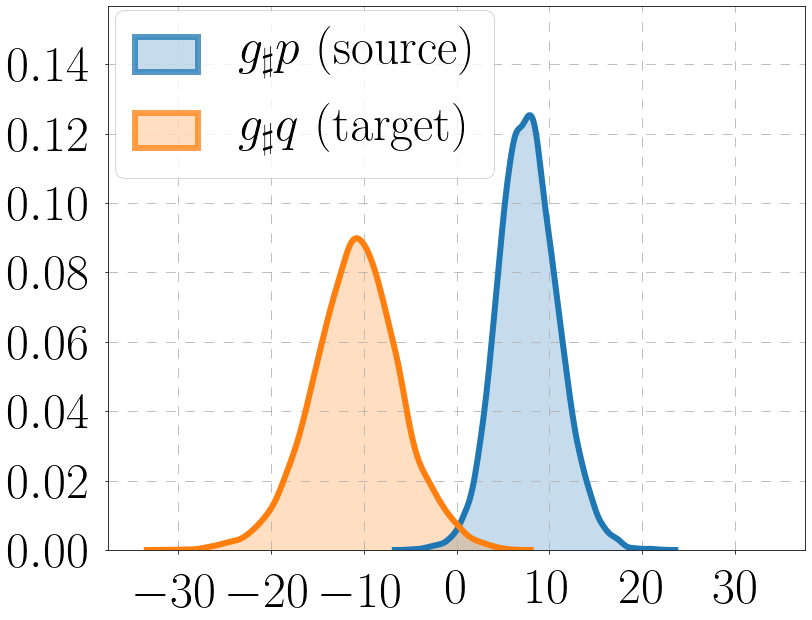

dann


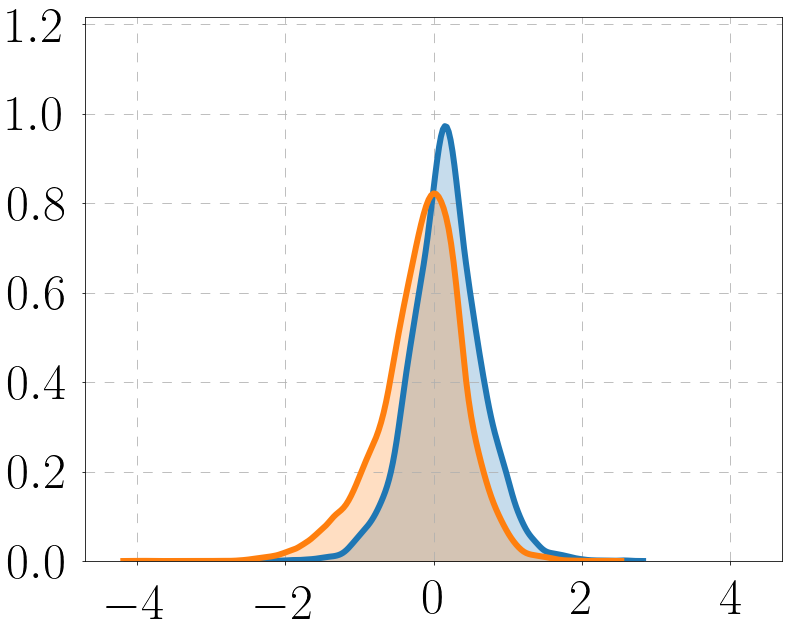

support_abs_h0


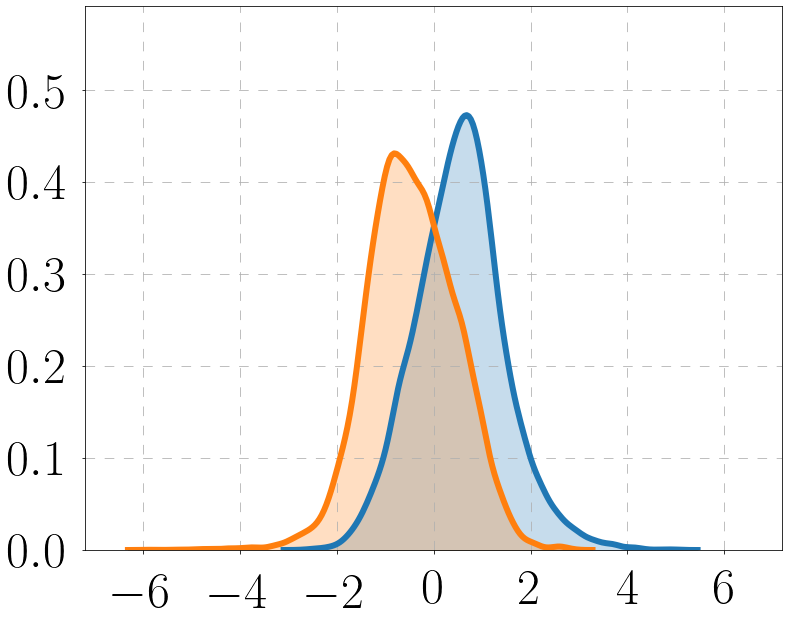

support_abs


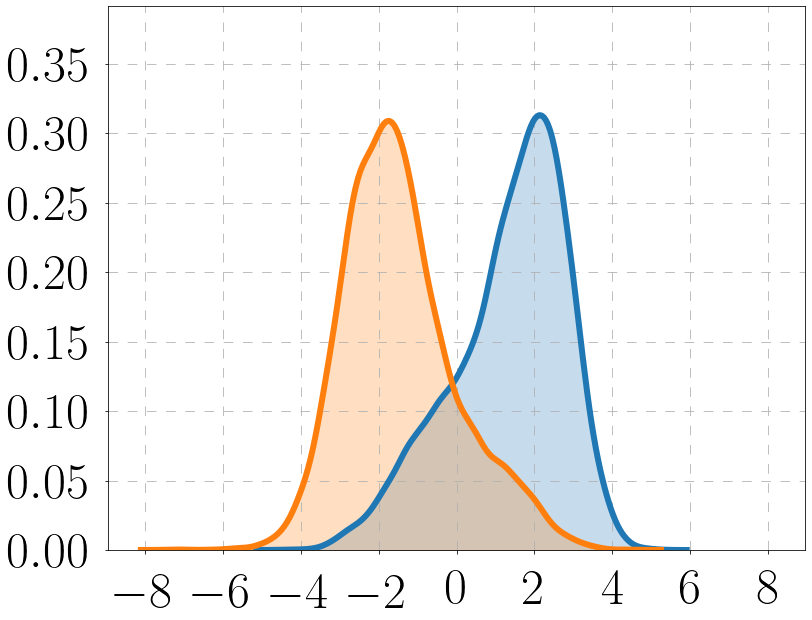

In [18]:
algorithms = [
    'dann_zero',
    'dann',
    'support_abs_h0',
    'support_abs',    
]


for i, algorithm_name in enumerate(algorithms):
    print(algorithm_name)
    disc_outputs = torch.load(f'./data_disc_hist/{algorithm_name}.pt')['disc_outputs'][0]    
    plt.figure(figsize=(12.5, 10.0))
    alignment_histplot(*disc_outputs, title=None, legend= i == 0, ylabel=False)
    plt.savefig(f'./figures/histplot_{algorithm_name}.pdf', format='pdf', bbox_inches='tight')
    plt.show()

# STL->CIFAR

In [19]:
prefix = 'stl_cifar/test_deep_cnn' # change to srl_cifar_deep_cnn
imbalance_levels = ['00', '10', '15', '20']
algorithms = [
    'source_only',
    'dann',
    'dann_ot',
    'wgp_dann',
    'vada',
    'iwdan',
    'iwcdan',    
    'sdann_4',
    'support_sq',
    'support_abs',
]

results = ResultsTable(prefix, algorithms, imbalance_levels, num_steps=40000)

stl_cifar/test_deep_cnn/seed_[1-5]/s_alpha_00/source_only[^0_]
Runs: 5
stl_cifar/test_deep_cnn/seed_[1-5]/s_alpha_10/source_only[^0_]
Runs: 5
stl_cifar/test_deep_cnn/seed_[1-5]/s_alpha_15/source_only[^0_]
Runs: 5
stl_cifar/test_deep_cnn/seed_[1-5]/s_alpha_20/source_only[^0_]
Runs: 5

stl_cifar/test_deep_cnn/seed_[1-5]/s_alpha_00/dann[^0_]
Runs: 5
stl_cifar/test_deep_cnn/seed_[1-5]/s_alpha_10/dann[^0_]
Runs: 5
stl_cifar/test_deep_cnn/seed_[1-5]/s_alpha_15/dann[^0_]
Runs: 5
stl_cifar/test_deep_cnn/seed_[1-5]/s_alpha_20/dann[^0_]
Runs: 5

stl_cifar/test_deep_cnn/seed_[1-5]/s_alpha_00/dann_ot[^0_]
Runs: 5
stl_cifar/test_deep_cnn/seed_[1-5]/s_alpha_10/dann_ot[^0_]
Runs: 5
stl_cifar/test_deep_cnn/seed_[1-5]/s_alpha_15/dann_ot[^0_]
Runs: 5
stl_cifar/test_deep_cnn/seed_[1-5]/s_alpha_20/dann_ot[^0_]
Runs: 5

stl_cifar/test_deep_cnn/seed_[1-5]/s_alpha_00/wgp_dann[^0_]
Runs: 5
stl_cifar/test_deep_cnn/seed_[1-5]/s_alpha_10/wgp_dann[^0_]
Runs: 5
stl_cifar/test_deep_cnn/seed_[1-5]/s_alpha_15/wgp_dan

In [20]:
results.print_table(['eval/target_val/accuracy_class_avg'], ResultsTable.mean_std_fn)

stl_cifar/test_deep_cnn eval/target_val/accuracy_class_avg
| algorithm   | 00               | 10               | 15               | 20               |
|:------------|:-----------------|:-----------------|:-----------------|:-----------------|
| source_only | 69.73 (0.58) [5] | 68.62 (0.78) [5] | 66.78 (0.47) [5] | 65.45 (1.29) [5] |
| dann        | 75.22 (0.41) [5] | 69.34 (1.02) [5] | 65.24 (1.61) [5] | 61.12 (4.03) [5] |
| dann_ot     | 75.99 (0.50) [5] | 67.96 (1.13) [5] | 63.21 (2.35) [5] | 58.65 (4.78) [5] |
| wgp_dann    | 74.99 (0.45) [5] | 66.72 (1.57) [5] | 60.97 (3.80) [5] | 57.42 (5.25) [5] |
| vada        | 76.64 (0.15) [5] | 70.27 (1.09) [5] | 65.41 (2.15) [5] | 61.55 (4.15) [5] |
| iwdan       | 70.39 (0.73) [5] | 68.67 (0.62) [5] | 66.71 (0.69) [5] | 64.40 (1.11) [5] |
| iwcdan      | 70.21 (0.50) [5] | 69.04 (0.94) [5] | 66.06 (1.10) [5] | 64.48 (1.38) [5] |
| sdann_4     | 71.66 (0.59) [5] | 71.04 (0.63) [5] | 69.24 (0.82) [5] | 66.78 (1.04) [5] |
| support_sq  | 71.73

In [21]:
results.print_table(['eval/target_val/accuracy_class_avg'], ResultsTable.quant_fn)

stl_cifar/test_deep_cnn eval/target_val/accuracy_class_avg
| algorithm   | 00                    | 10                    | 15                    | 20                    |
|:------------|:----------------------|:----------------------|:----------------------|:----------------------|
| source_only | 69.75 69.88 70.04 [5] | 68.30 68.80 69.25 [5] | 66.39 66.82 67.16 [5] | 64.76 65.84 66.68 [5] |
| dann        | 74.87 75.26 75.38 [5] | 68.60 69.87 70.05 [5] | 63.74 64.93 67.07 [5] | 57.39 63.34 64.78 [5] |
| dann_ot     | 75.85 75.97 76.04 [5] | 67.14 67.66 68.85 [5] | 60.93 64.50 65.12 [5] | 54.42 61.26 62.03 [5] |
| wgp_dann    | 74.68 74.81 75.05 [5] | 65.33 67.73 67.92 [5] | 57.09 63.32 63.40 [5] | 54.26 59.03 61.85 [5] |
| vada        | 76.55 76.66 76.72 [5] | 70.02 70.60 71.04 [5] | 65.42 66.07 66.48 [5] | 60.23 63.22 64.72 [5] |
| iwdan       | 69.87 69.93 70.67 [5] | 68.64 68.72 69.14 [5] | 65.87 67.09 67.32 [5] | 63.56 64.39 64.86 [5] |
| iwcdan      | 70.06 70.15 70.15 [5] | 69.11

In [22]:
results.print_table(['eval/target_val/accuracy_class_min'], ResultsTable.quant_fn)

stl_cifar/test_deep_cnn eval/target_val/accuracy_class_min
| algorithm   | 00                    | 10                    | 15                    | 20                    |
|:------------|:----------------------|:----------------------|:----------------------|:----------------------|
| source_only | 45.30 49.79 50.65 [5] | 45.35 47.21 48.15 [5] | 45.76 46.04 47.02 [5] | 41.58 43.74 44.65 [5] |
| dann        | 54.25 54.61 56.63 [5] | 40.69 44.75 45.05 [5] | 33.95 34.87 36.83 [5] | 21.19 27.04 28.47 [5] |
| dann_ot     | 54.32 55.25 55.52 [5] | 36.53 42.96 43.74 [5] | 29.28 34.42 34.58 [5] | 23.15 24.32 25.47 [5] |
| wgp_dann    | 53.29 53.47 54.36 [5] | 34.36 38.62 40.95 [5] | 26.26 27.00 32.41 [5] | 18.62 21.89 22.46 [5] |
| vada        | 53.50 56.89 58.32 [5] | 43.96 47.67 48.77 [5] | 33.27 35.74 39.31 [5] | 25.19 25.54 27.98 [5] |
| iwdan       | 47.94 50.55 50.63 [5] | 44.75 45.84 50.52 [5] | 40.45 44.67 44.75 [5] | 34.47 36.77 37.88 [5] |
| iwcdan      | 42.39 47.83 49.25 [5] | 46.34

In [23]:
results.print_table(['eval/target_val/accuracy_class_avg', 'eval/target_val/accuracy_class_min'], 
                    ResultsTable.quant_latex_fn, tablefmt='latex_raw', sep=' & ')

stl_cifar/test_deep_cnn eval/target_val/accuracy_class_avg eval/target_val/accuracy_class_min
\begin{tabular}{lllll}
\hline
 algorithm   & 00                                                  & 10                                                  & 15                                                  & 20                                                  \\
\hline
 source_only & $ 69.9_{~69.8}^{~70.0} $ & $ 49.8_{~45.3}^{~50.6} $ & $ 68.8_{~68.3}^{~69.3} $ & $ 47.2_{~45.3}^{~48.2} $ & $ 66.8_{~66.4}^{~67.2} $ & $ 46.0_{~45.8}^{~47.0} $ & $ 65.8_{~64.8}^{~66.7} $ & $ 43.7_{~41.6}^{~44.6} $ \\
 dann        & $ 75.3_{~74.9}^{~75.4} $ & $ 54.6_{~54.2}^{~56.6} $ & $ 69.9_{~68.6}^{~70.1} $ & $ 44.8_{~40.7}^{~45.1} $ & $ 64.9_{~63.7}^{~67.1} $ & $ 34.9_{~33.9}^{~36.8} $ & $ 63.3_{~57.4}^{~64.8} $ & $ 27.0_{~21.2}^{~28.5} $ \\
 dann_ot     & $ 76.0_{~75.8}^{~76.0} $ & $ 55.2_{~54.3}^{~55.5} $ & $ 67.7_{~67.1}^{~68.9} $ & $ 43.0_{~36.5}^{~43.7} $ & $ 64.5_{~60.9}^{~65.1} $ & $ 34.4_{~29.3}^{~34.6} 

In [24]:
results.print_table(['eval/target_val/accuracy_class_avg', 'eval/target_val/accuracy_class_min'], ResultsTable.quant_latex_fn)

stl_cifar/test_deep_cnn eval/target_val/accuracy_class_avg eval/target_val/accuracy_class_min
| algorithm   | 00                                                | 10                                                | 15                                                | 20                                                |
|:------------|:--------------------------------------------------|:--------------------------------------------------|:--------------------------------------------------|:--------------------------------------------------|
| source_only | $ 69.9_{~69.8}^{~70.0} $ $ 49.8_{~45.3}^{~50.6} $ | $ 68.8_{~68.3}^{~69.3} $ $ 47.2_{~45.3}^{~48.2} $ | $ 66.8_{~66.4}^{~67.2} $ $ 46.0_{~45.8}^{~47.0} $ | $ 65.8_{~64.8}^{~66.7} $ $ 43.7_{~41.6}^{~44.6} $ |
| dann        | $ 75.3_{~74.9}^{~75.4} $ $ 54.6_{~54.2}^{~56.6} $ | $ 69.9_{~68.6}^{~70.1} $ $ 44.8_{~40.7}^{~45.1} $ | $ 64.9_{~63.7}^{~67.1} $ $ 34.9_{~33.9}^{~36.8} $ | $ 63.3_{~57.4}^{~64.8} $ $ 27.0_{~21.2}^{~28.5} $ |
| dann_ot 

| Algorithm   | $\alpha = 0.0$                                    | $\alpha = 1.0$                                | $\alpha = 1.5$                                         | $\alpha = 2.0$                                    |
|:------------|:--------------------------------------------------|:--------------------------------------------------|:--------------------------------------------------|:--------------------------------------------------|
| source_only | $ 69.9_{~69.8}^{~70.0} $ $ 49.8_{~45.3}^{~50.6} $ | $ 68.8_{~68.3}^{~69.3} $ $ 47.2_{~45.3}^{~48.2} $ | $ 66.8_{~66.4}^{~67.2} $ $ 46.0_{~45.8}^{~47.0} $ | $ 65.8_{~64.8}^{~66.7} $ $ 43.7_{~41.6}^{~44.6} $ |
| dann        | $ 75.3_{~74.9}^{~75.4} $ $ 54.6_{~54.2}^{~56.6} $ | $ 69.9_{~68.6}^{~70.1} $ $ 44.8_{~40.7}^{~45.1} $ | $ 64.9_{~63.7}^{~67.1} $ $ 34.9_{~33.9}^{~36.8} $ | $ 63.3_{~57.4}^{~64.8} $ $ 27.0_{~21.2}^{~28.5} $ |
| dann_ot     | $ 76.0_{~75.8}^{~76.0} $ $ 55.2_{~54.3}^{~55.5} $ | $ 67.7_{~67.1}^{~68.9} $ $ 43.0_{~36.5}^{~43.7} $ | $ 64.5_{~60.9}^{~65.1} $ $ 34.4_{~29.3}^{~34.6} $ | $ 61.3_{~54.4}^{~62.0} $ $ 24.3_{~23.2}^{~25.5} $ |
| wgp_dann    | $ 74.8_{~74.7}^{~75.1} $ $ 53.5_{~53.3}^{~54.4} $ | $ 67.7_{~65.3}^{~67.9} $ $ 38.6_{~34.4}^{~41.0} $ | $ 63.3_{~57.1}^{~63.4} $ $ 27.0_{~26.3}^{~32.4} $ | $ 59.0_{~54.3}^{~61.8} $ $ 21.9_{~18.6}^{~22.5} $ |
| vada        | $ 76.7_{~76.6}^{~76.7} $ $ 56.9_{~53.5}^{~58.3} $ | $ 70.6_{~70.0}^{~71.0} $ $ 47.7_{~44.0}^{~48.8} $ | $ 66.1_{~65.4}^{~66.5} $ $ 35.7_{~33.3}^{~39.3} $ | $ 63.2_{~60.2}^{~64.7} $ $ 25.5_{~25.2}^{~28.0} $ |
| iwdan       | $ 69.9_{~69.9}^{~70.7} $ $ 50.5_{~47.9}^{~50.6} $ | $ 68.7_{~68.6}^{~69.1} $ $ 45.8_{~44.8}^{~50.5} $ | $ 67.1_{~65.9}^{~67.3} $ $ 44.7_{~40.4}^{~44.8} $ | $ 64.4_{~63.6}^{~64.9} $ $ 36.8_{~34.5}^{~37.9} $ |
| iwcdan      | $ 70.1_{~70.1}^{~70.2} $ $ 47.8_{~42.4}^{~49.3} $ | $ 69.4_{~69.1}^{~69.4} $ $ 47.1_{~46.3}^{~51.3} $ | $ 66.1_{~65.0}^{~67.2} $ $ 39.9_{~37.7}^{~40.8} $ | $ 64.5_{~63.9}^{~65.1} $ $ 37.0_{~35.5}^{~40.2} $ |
| sdann_4     | $ 71.8_{~71.7}^{~72.1} $ $ 52.1_{~52.1}^{~52.8} $ | $ 71.1_{~70.4}^{~71.7} $ $ 49.9_{~48.1}^{~51.8} $ | $ 69.4_{~68.7}^{~70.0} $ $ 48.6_{~43.5}^{~49.0} $ | $ 66.4_{~66.2}^{~67.9} $ $ 39.0_{~33.6}^{~47.1} $ |
| support_sq  | $ 71.7_{~71.7}^{~71.9} $ $ 52.9_{~46.7}^{~53.4} $ | $ 70.7_{~70.4}^{~71.0} $ $ 51.6_{~46.8}^{~52.7} $ | $ 69.2_{~69.2}^{~69.3} $ $ 45.6_{~43.3}^{~52.0} $ | $ 68.1_{~67.2}^{~68.2} $ $ 44.7_{~39.8}^{~45.9} $ |
| support_abs | $ 71.6_{~71.2}^{~71.7} $ $ 49.0_{~48.4}^{~53.5} $ | $ 70.9_{~70.8}^{~71.0} $ $ 49.2_{~47.3}^{~50.0} $ | $ 69.6_{~69.6}^{~69.9} $ $ 43.2_{~42.1}^{~49.5} $ | $ 67.8_{~66.6}^{~68.2} $ $ 40.9_{~35.4}^{~49.0} $ |

In [25]:
results.print_table(['eval/target_val/accuracy_class_avg', 'eval/target_val/accuracy_class_min'],
                    ResultsTable.quant_latex_fn, tablefmt='latex_raw', sep=' & ')

stl_cifar/test_deep_cnn eval/target_val/accuracy_class_avg eval/target_val/accuracy_class_min
\begin{tabular}{lllll}
\hline
 algorithm   & 00                                                  & 10                                                  & 15                                                  & 20                                                  \\
\hline
 source_only & $ 69.9_{~69.8}^{~70.0} $ & $ 49.8_{~45.3}^{~50.6} $ & $ 68.8_{~68.3}^{~69.3} $ & $ 47.2_{~45.3}^{~48.2} $ & $ 66.8_{~66.4}^{~67.2} $ & $ 46.0_{~45.8}^{~47.0} $ & $ 65.8_{~64.8}^{~66.7} $ & $ 43.7_{~41.6}^{~44.6} $ \\
 dann        & $ 75.3_{~74.9}^{~75.4} $ & $ 54.6_{~54.2}^{~56.6} $ & $ 69.9_{~68.6}^{~70.1} $ & $ 44.8_{~40.7}^{~45.1} $ & $ 64.9_{~63.7}^{~67.1} $ & $ 34.9_{~33.9}^{~36.8} $ & $ 63.3_{~57.4}^{~64.8} $ & $ 27.0_{~21.2}^{~28.5} $ \\
 dann_ot     & $ 76.0_{~75.8}^{~76.0} $ & $ 55.2_{~54.3}^{~55.5} $ & $ 67.7_{~67.1}^{~68.9} $ & $ 43.0_{~36.5}^{~43.7} $ & $ 64.5_{~60.9}^{~65.1} $ & $ 34.4_{~29.3}^{~34.6} 

## STL->CIFAR entropy experiment


In [26]:
prefix = 'stl_cifar/test_deep_cnn' # change to stl_cifar/deep_cnn
imbalance_levels = ['00', '10', '15', '20']
algorithms = [ 
    'dann_no_trg_ent',
    'dann',
    'vada',
    'iwdan_no_trg_ent',
    'iwdan',
    'iwcdan_no_trg_ent',
    'iwcdan',    
    'sdann_4_no_trg_ent',    
    'sdann_4',        
    'support_sq_no_trg_ent',
    'support_sq',    
    'support_abs_no_trg_ent',
    'support_abs',    
]

results = ResultsTable(prefix, algorithms, imbalance_levels, num_steps=40000)

stl_cifar/test_deep_cnn/seed_[1-5]/s_alpha_00/dann_no_trg_ent[^0_]
Runs: 5
stl_cifar/test_deep_cnn/seed_[1-5]/s_alpha_10/dann_no_trg_ent[^0_]
Runs: 5
stl_cifar/test_deep_cnn/seed_[1-5]/s_alpha_15/dann_no_trg_ent[^0_]
Runs: 5
stl_cifar/test_deep_cnn/seed_[1-5]/s_alpha_20/dann_no_trg_ent[^0_]
Runs: 5

stl_cifar/test_deep_cnn/seed_[1-5]/s_alpha_00/dann[^0_]
Runs: 5
stl_cifar/test_deep_cnn/seed_[1-5]/s_alpha_10/dann[^0_]
Runs: 5
stl_cifar/test_deep_cnn/seed_[1-5]/s_alpha_15/dann[^0_]
Runs: 5
stl_cifar/test_deep_cnn/seed_[1-5]/s_alpha_20/dann[^0_]
Runs: 5

stl_cifar/test_deep_cnn/seed_[1-5]/s_alpha_00/vada[^0_]
Runs: 5
stl_cifar/test_deep_cnn/seed_[1-5]/s_alpha_10/vada[^0_]
Runs: 5
stl_cifar/test_deep_cnn/seed_[1-5]/s_alpha_15/vada[^0_]
Runs: 5
stl_cifar/test_deep_cnn/seed_[1-5]/s_alpha_20/vada[^0_]
Runs: 5

stl_cifar/test_deep_cnn/seed_[1-5]/s_alpha_00/iwdan_no_trg_ent[^0_]
Runs: 5
stl_cifar/test_deep_cnn/seed_[1-5]/s_alpha_10/iwdan_no_trg_ent[^0_]
Runs: 5
stl_cifar/test_deep_cnn/seed_[1-5

In [27]:
results.print_table(['eval/target_val/accuracy_class_avg'], ResultsTable.quant_fn)

stl_cifar/test_deep_cnn eval/target_val/accuracy_class_avg
| algorithm              | 00                    | 10                    | 15                    | 20                    |
|:-----------------------|:----------------------|:----------------------|:----------------------|:----------------------|
| dann_no_trg_ent        | 74.10 74.61 75.05 [5] | 66.96 68.40 69.18 [5] | 62.81 65.68 65.87 [5] | 60.00 62.50 64.60 [5] |
| dann                   | 74.87 75.26 75.38 [5] | 68.60 69.87 70.05 [5] | 63.74 64.93 67.07 [5] | 57.39 63.34 64.78 [5] |
| vada                   | 76.55 76.66 76.72 [5] | 70.02 70.60 71.04 [5] | 65.42 66.07 66.48 [5] | 60.23 63.22 64.72 [5] |
| iwdan_no_trg_ent       | 70.20 70.35 70.67 [5] | 68.39 68.58 68.84 [5] | 66.03 66.72 67.87 [5] | 62.92 63.94 66.08 [5] |
| iwdan                  | 69.87 69.93 70.67 [5] | 68.64 68.72 69.14 [5] | 65.87 67.09 67.32 [5] | 63.56 64.39 64.86 [5] |
| iwcdan_no_trg_ent      | 70.01 70.07 70.76 [5] | 68.23 68.58 69.37 [5] | 65.88

In [28]:
results.print_table(['eval/target_val/accuracy_class_min'], ResultsTable.quant_fn)

stl_cifar/test_deep_cnn eval/target_val/accuracy_class_min
| algorithm              | 00                    | 10                    | 15                    | 20                    |
|:-----------------------|:----------------------|:----------------------|:----------------------|:----------------------|
| dann_no_trg_ent        | 49.90 51.52 55.04 [5] | 41.19 43.15 43.68 [5] | 29.57 35.47 36.15 [5] | 25.68 27.45 27.49 [5] |
| dann                   | 54.25 54.61 56.63 [5] | 40.69 44.75 45.05 [5] | 33.95 34.87 36.83 [5] | 21.19 27.04 28.47 [5] |
| vada                   | 53.50 56.89 58.32 [5] | 43.96 47.67 48.77 [5] | 33.27 35.74 39.31 [5] | 25.19 25.54 27.98 [5] |
| iwdan_no_trg_ent       | 46.75 47.22 48.02 [5] | 43.16 43.62 46.34 [5] | 43.27 44.67 46.15 [5] | 32.69 36.48 37.34 [5] |
| iwdan                  | 47.94 50.55 50.63 [5] | 44.75 45.84 50.52 [5] | 40.45 44.67 44.75 [5] | 34.47 36.77 37.88 [5] |
| iwcdan_no_trg_ent      | 49.05 50.54 50.85 [5] | 41.16 44.23 45.76 [5] | 43.72

In [29]:
results.print_table(['eval/target_val/accuracy_class_avg', 'eval/target_val/accuracy_class_min'], ResultsTable.quant_latex_fn)

stl_cifar/test_deep_cnn eval/target_val/accuracy_class_avg eval/target_val/accuracy_class_min
| algorithm              | 00                                                | 10                                                | 15                                                | 20                                                |
|:-----------------------|:--------------------------------------------------|:--------------------------------------------------|:--------------------------------------------------|:--------------------------------------------------|
| dann_no_trg_ent        | $ 74.6_{~74.1}^{~75.1} $ $ 51.5_{~49.9}^{~55.0} $ | $ 68.4_{~67.0}^{~69.2} $ $ 43.2_{~41.2}^{~43.7} $ | $ 65.7_{~62.8}^{~65.9} $ $ 35.5_{~29.6}^{~36.2} $ | $ 62.5_{~60.0}^{~64.6} $ $ 27.5_{~25.7}^{~27.5} $ |
| dann                   | $ 75.3_{~74.9}^{~75.4} $ $ 54.6_{~54.2}^{~56.6} $ | $ 69.9_{~68.6}^{~70.1} $ $ 44.8_{~40.7}^{~45.1} $ | $ 64.9_{~63.7}^{~67.1} $ $ 34.9_{~33.9}^{~36.8} $ | $ 63.3_{~57.4}^{~6

| Algorithm   | $\lambda_{\text{ent}}$ | $\alpha = 0.0$                                    | $\alpha = 1.0$                                | $\alpha = 1.5$                                         | $\alpha = 2.0$                                    |
|:------------|:-----------------------|:--------------------------------------------------|:--------------------------------------------------|:--------------------------------------------------|:--------------------------------------------------|
| DANN        | $0$                    |$ 74.6_{74.1}^{75.1} $ $ 51.5_{49.9}^{55.0} $ | $ 68.4_{67.0}^{69.2} $ $ 43.2_{41.2}^{43.7} $ | $ 65.7_{62.8}^{65.9} $ $ 35.5_{29.6}^{36.2} $ | $ 62.5_{60.0}^{64.6} $ $ 27.5_{25.7}^{27.5} $ |
| DANN        | $0.1$                  | $ 75.3_{74.9}^{75.4} $ $ 54.6_{54.2}^{56.6} $ | $ 69.9_{68.6}^{70.1} $ $ 44.8_{40.7}^{45.1} $ | $ 64.9_{63.7}^{67.1} $ $ 34.9_{33.9}^{36.8} $ | $ 63.3_{57.4}^{64.8} $ $ 27.0_{21.2}^{28.5} $ |
| VADA        | $0.1$                  | $ 76.7_{76.6}^{76.7} $ $ 56.9_{53.5}^{58.3} $ | $ 70.6_{70.0}^{71.0} $ $ 47.7_{44.0}^{48.8} $ | $ 66.1_{65.4}^{66.5} $ $ 35.7_{33.3}^{39.3} $ | $ 63.2_{60.2}^{64.7} $ $ 25.5_{25.2}^{28.0} $ |
| IWDAN       | $0$                    | $ 70.4_{70.2}^{70.7} $ $ 47.2_{46.8}^{48.0} $ | $ 68.6_{68.4}^{68.8} $ $ 43.6_{43.2}^{46.3} $ | $ 66.7_{66.0}^{67.9} $ $ 44.7_{43.3}^{46.2} $ | $ 63.9_{62.9}^{66.1} $ $ 36.5_{32.7}^{37.3} $ |
| IWDAN       | $0.1$                  | $ 69.9_{69.9}^{70.7} $ $ 50.5_{47.9}^{50.6} $ | $ 68.7_{68.6}^{69.1} $ $ 45.8_{44.8}^{50.5} $ | $ 67.1_{65.9}^{67.3} $ $ 44.7_{40.4}^{44.8} $ | $ 64.4_{63.6}^{64.9} $ $ 36.8_{34.5}^{37.9} $ |
| IWCDAN      | $0$                    | $ 70.1_{70.0}^{70.8} $ $ 50.5_{49.1}^{50.8} $ | $ 68.6_{68.2}^{69.4} $ $ 44.2_{41.2}^{45.8} $ | $ 66.0_{65.9}^{66.0} $ $ 45.0_{43.7}^{47.8} $ | $ 63.8_{62.3}^{64.1} $ $ 37.3_{33.6}^{37.7} $ |
| IWCDAN      | $0.1$                  | $ 70.1_{70.1}^{70.2} $ $ 47.8_{42.4}^{49.3} $ | $ 69.4_{69.1}^{69.4} $ $ 47.1_{46.3}^{51.3} $ | $ 66.1_{65.0}^{67.2} $ $ 39.9_{37.7}^{40.8} $ | $ 64.5_{63.9}^{65.1} $ $ 37.0_{35.5}^{40.2} $ |
| sDANN-4     | $0$                  | $ 69.4_{68.8}^{70.0} $ $ 46.5_{45.1}^{49.7} $ | $ 69.6_{69.3}^{69.7} $ $ 49.1_{47.4}^{49.2} $ | $ 68.0_{67.8}^{68.6} $ $ 48.2_{42.6}^{48.8} $ | $ 66.3_{64.2}^{66.4} $ $ 40.7_{36.6}^{42.9} $ |
| sDANN-4     | $0.1$                | $ 71.8_{71.7}^{72.1} $ $ 52.1_{52.1}^{52.8} $ | $ 71.1_{70.4}^{71.7} $ $ 49.9_{48.1}^{51.8} $ | $ 69.4_{68.7}^{70.0} $ $ 48.6_{43.5}^{49.0} $ | $ 66.4_{66.2}^{67.9} $ $ 39.0_{33.6}^{47.1} $ |
| ASA-sq      | $0$                  | $ 69.9_{69.9}^{70.3} $ $ 48.0_{46.6}^{50.1} $ | $ 68.8_{68.6}^{68.9} $ $ 47.3_{45.3}^{49.3} $ | $ 68.1_{67.2}^{68.7} $ $ 45.4_{45.2}^{47.8} $ | $ 65.7_{65.6}^{66.4} $ $ 43.6_{41.3}^{45.0} $ |
| ASA-sq      | $0.1$                | $ 71.7_{71.7}^{71.9} $ $ 52.9_{46.7}^{53.4} $ | $ 70.7_{70.4}^{71.0} $ $ 51.6_{46.8}^{52.7} $ | $ 69.2_{69.2}^{69.3} $ $ 45.6_{43.3}^{52.0} $ | $ 68.1_{67.2}^{68.2} $ $ 44.7_{39.8}^{45.9} $ |
| ASA-abs     | $0$                  | $ 69.8_{68.9}^{70.0} $ $ 45.7_{45.4}^{48.0} $ | $ 68.4_{68.4}^{68.6} $ $ 44.3_{44.0}^{46.8} $ | $ 67.9_{67.0}^{68.1} $ $ 46.6_{40.4}^{48.4} $ | $ 66.3_{65.7}^{66.9} $ $ 41.6_{40.3}^{44.9} $ |
| ASA-abs     | $0.1$                | $ 71.6_{71.2}^{71.7} $ $ 49.0_{48.4}^{53.5} $ | $ 70.9_{70.8}^{71.0} $ $ 49.2_{47.3}^{50.0} $ | $ 69.6_{69.6}^{69.9} $ $ 43.2_{42.1}^{49.5} $ | $ 67.8_{66.6}^{68.2} $ $ 40.9_{35.4}^{49.0} $ |

| Algorithm   | $\lambda_{\text{ent}}$ | $\alpha = 0.0$                                    | $\alpha = 1.0$                                | $\alpha = 1.5$                                         | $\alpha = 2.0$                                    |
|:------------|:-----------------------|:--------------------------------------------------|:--------------------------------------------------|:--------------------------------------------------|:--------------------------------------------------|
| DANN        | $0$                    |$ 74.6_{74.1}^{75.1} $ $ 51.5_{49.9}^{55.0} $ | $ 68.4_{67.0}^{69.2} $ $ 43.2_{41.2}^{43.7} $ | $ 65.7_{62.8}^{65.9} $ $ 35.5_{29.6}^{36.2} $ | $ 62.5_{60.0}^{64.6} $ $ 27.5_{25.7}^{27.5} $ |
| IWDAN       | $0$                    | $ 70.4_{70.2}^{70.7} $ $ 47.2_{46.8}^{48.0} $ | $ 68.6_{68.4}^{68.8} $ $ 43.6_{43.2}^{46.3} $ | $ 66.7_{66.0}^{67.9} $ $ 44.7_{43.3}^{46.2} $ | $ 63.9_{62.9}^{66.1} $ $ 36.5_{32.7}^{37.3} $ |
| IWCDAN      | $0$                    | $ 70.1_{70.0}^{70.8} $ $ 50.5_{49.1}^{50.8} $ | $ 68.6_{68.2}^{69.4} $ $ 44.2_{41.2}^{45.8} $ | $ 66.0_{65.9}^{66.0} $ $ 45.0_{43.7}^{47.8} $ | $ 63.8_{62.3}^{64.1} $ $ 37.3_{33.6}^{37.7} $ |
| sDANN-4     | $0$                  | $ 69.4_{68.8}^{70.0} $ $ 46.5_{45.1}^{49.7} $ | $ 69.6_{69.3}^{69.7} $ $ 49.1_{47.4}^{49.2} $ | $ 68.0_{67.8}^{68.6} $ $ 48.2_{42.6}^{48.8} $ | $ 66.3_{64.2}^{66.4} $ $ 40.7_{36.6}^{42.9} $ |
| ASA-sq      | $0$                  | $ 69.9_{69.9}^{70.3} $ $ 48.0_{46.6}^{50.1} $ | $ 68.8_{68.6}^{68.9} $ $ 47.3_{45.3}^{49.3} $ | $ 68.1_{67.2}^{68.7} $ $ 45.4_{45.2}^{47.8} $ | $ 65.7_{65.6}^{66.4} $ $ 43.6_{41.3}^{45.0} $ |
| ASA-abs     | $0$                  | $ 69.8_{68.9}^{70.0} $ $ 45.7_{45.4}^{48.0} $ | $ 68.4_{68.4}^{68.6} $ $ 44.3_{44.0}^{46.8} $ | $ 67.9_{67.0}^{68.1} $ $ 46.6_{40.4}^{48.4} $ | $ 66.3_{65.7}^{66.9} $ $ 41.6_{40.3}^{44.9} $ |

| Algorithm   | $\lambda_{\text{ent}}$ | $\alpha = 0.0$                                    | $\alpha = 1.0$                                | $\alpha = 1.5$                                         | $\alpha = 2.0$                                    |
|:------------|:-----------------------|:--------------------------------------------------|:--------------------------------------------------|:--------------------------------------------------|:--------------------------------------------------|
| DANN        | $0.1$                  | $ 75.3_{74.9}^{75.4} $ $ 54.6_{54.2}^{56.6} $ | $ 69.9_{68.6}^{70.1} $ $ 44.8_{40.7}^{45.1} $ | $ 64.9_{63.7}^{67.1} $ $ 34.9_{33.9}^{36.8} $ | $ 63.3_{57.4}^{64.8} $ $ 27.0_{21.2}^{28.5} $ |
| IWDAN       | $0.1$                  | $ 69.9_{69.9}^{70.7} $ $ 50.5_{47.9}^{50.6} $ | $ 68.7_{68.6}^{69.1} $ $ 45.8_{44.8}^{50.5} $ | $ 67.1_{65.9}^{67.3} $ $ 44.7_{40.4}^{44.8} $ | $ 64.4_{63.6}^{64.9} $ $ 36.8_{34.5}^{37.9} $ |
| IWCDAN      | $0.1$                  | $ 70.1_{70.1}^{70.2} $ $ 47.8_{42.4}^{49.3} $ | $ 69.4_{69.1}^{69.4} $ $ 47.1_{46.3}^{51.3} $ | $ 66.1_{65.0}^{67.2} $ $ 39.9_{37.7}^{40.8} $ | $ 64.5_{63.9}^{65.1} $ $ 37.0_{35.5}^{40.2} $ |
| sDANN-4     | $0.1$                | $ 71.8_{71.7}^{72.1} $ $ 52.1_{52.1}^{52.8} $ | $ 71.1_{70.4}^{71.7} $ $ 49.9_{48.1}^{51.8} $ | $ 69.4_{68.7}^{70.0} $ $ 48.6_{43.5}^{49.0} $ | $ 66.4_{66.2}^{67.9} $ $ 39.0_{33.6}^{47.1} $ |
| ASA-sq      | $0.1$                | $ 71.7_{71.7}^{71.9} $ $ 52.9_{46.7}^{53.4} $ | $ 70.7_{70.4}^{71.0} $ $ 51.6_{46.8}^{52.7} $ | $ 69.2_{69.2}^{69.3} $ $ 45.6_{43.3}^{52.0} $ | $ 68.1_{67.2}^{68.2} $ $ 44.7_{39.8}^{45.9} $ |
| ASA-abs     | $0.1$                | $ 71.6_{71.2}^{71.7} $ $ 49.0_{48.4}^{53.5} $ | $ 70.9_{70.8}^{71.0} $ $ 49.2_{47.3}^{50.0} $ | $ 69.6_{69.6}^{69.9} $ $ 43.2_{42.1}^{49.5} $ | $ 67.8_{66.6}^{68.2} $ $ 40.9_{35.4}^{49.0} $ |

In [30]:
results.print_table(['eval/target_val/accuracy_class_avg', 'eval/target_val/accuracy_class_min'], ResultsTable.quant_latex_fn,
                    tablefmt='latex_raw', sep=' & ')

stl_cifar/test_deep_cnn eval/target_val/accuracy_class_avg eval/target_val/accuracy_class_min
\begin{tabular}{lllll}
\hline
 algorithm              & 00                                                  & 10                                                  & 15                                                  & 20                                                  \\
\hline
 dann_no_trg_ent        & $ 74.6_{~74.1}^{~75.1} $ & $ 51.5_{~49.9}^{~55.0} $ & $ 68.4_{~67.0}^{~69.2} $ & $ 43.2_{~41.2}^{~43.7} $ & $ 65.7_{~62.8}^{~65.9} $ & $ 35.5_{~29.6}^{~36.2} $ & $ 62.5_{~60.0}^{~64.6} $ & $ 27.5_{~25.7}^{~27.5} $ \\
 dann                   & $ 75.3_{~74.9}^{~75.4} $ & $ 54.6_{~54.2}^{~56.6} $ & $ 69.9_{~68.6}^{~70.1} $ & $ 44.8_{~40.7}^{~45.1} $ & $ 64.9_{~63.7}^{~67.1} $ & $ 34.9_{~33.9}^{~36.8} $ & $ 63.3_{~57.4}^{~64.8} $ & $ 27.0_{~21.2}^{~28.5} $ \\
 vada                   & $ 76.7_{~76.6}^{~76.7} $ & $ 56.9_{~53.5}^{~58.3} $ & $ 70.6_{~70.0}^{~71.0} $ & $ 47.7_{~44.0}^{~48.8} $ & $ 66.1

# STL->CIFAR VADA (0.01) and DANN (1.0)

In [31]:
prefix = 'stl_cifar/test_deep_cnn' # change to stl_cifar/deep_cnn
imbalance_levels = ['00', '10', '15', '20']
algorithms = [
    'source_only',    
    'dann_aw_001',
    'dann',
    'dann_aw_1',
    'vada',
    'vada_001',    
    'sdann_4',            
    'support_sq',
    'support_sq_vat_trg',    
    'support_sq_vat_trg_aw_001',
    'support_sq_vat_trg_aw_1',    
]

results = ResultsTable(prefix, algorithms, imbalance_levels, num_steps=40000)

stl_cifar/test_deep_cnn/seed_[1-5]/s_alpha_00/source_only[^0_]
Runs: 5
stl_cifar/test_deep_cnn/seed_[1-5]/s_alpha_10/source_only[^0_]
Runs: 5
stl_cifar/test_deep_cnn/seed_[1-5]/s_alpha_15/source_only[^0_]
Runs: 5
stl_cifar/test_deep_cnn/seed_[1-5]/s_alpha_20/source_only[^0_]
Runs: 5

stl_cifar/test_deep_cnn/seed_[1-5]/s_alpha_00/dann_aw_001[^0_]
Runs: 5
stl_cifar/test_deep_cnn/seed_[1-5]/s_alpha_10/dann_aw_001[^0_]
Runs: 5
stl_cifar/test_deep_cnn/seed_[1-5]/s_alpha_15/dann_aw_001[^0_]
Runs: 5
stl_cifar/test_deep_cnn/seed_[1-5]/s_alpha_20/dann_aw_001[^0_]
Runs: 5

stl_cifar/test_deep_cnn/seed_[1-5]/s_alpha_00/dann[^0_]
Runs: 5
stl_cifar/test_deep_cnn/seed_[1-5]/s_alpha_10/dann[^0_]
Runs: 5
stl_cifar/test_deep_cnn/seed_[1-5]/s_alpha_15/dann[^0_]
Runs: 5
stl_cifar/test_deep_cnn/seed_[1-5]/s_alpha_20/dann[^0_]
Runs: 5

stl_cifar/test_deep_cnn/seed_[1-5]/s_alpha_00/dann_aw_1[^0_]
Runs: 5
stl_cifar/test_deep_cnn/seed_[1-5]/s_alpha_10/dann_aw_1[^0_]
Runs: 5
stl_cifar/test_deep_cnn/seed_[1-5]/

In [32]:
results.print_table(['eval/target_val/accuracy_class_avg'], ResultsTable.quant_fn)

stl_cifar/test_deep_cnn eval/target_val/accuracy_class_avg
| algorithm                 | 00                    | 10                    | 15                    | 20                    |
|:--------------------------|:----------------------|:----------------------|:----------------------|:----------------------|
| source_only               | 69.75 69.88 70.04 [5] | 68.30 68.80 69.25 [5] | 66.39 66.82 67.16 [5] | 64.76 65.84 66.68 [5] |
| dann_aw_001               | 72.22 72.25 72.67 [5] | 69.73 70.59 71.15 [5] | 67.21 68.50 68.68 [5] | 64.08 65.87 66.00 [5] |
| dann                      | 74.87 75.26 75.38 [5] | 68.60 69.87 70.05 [5] | 63.74 64.93 67.07 [5] | 57.39 63.34 64.78 [5] |
| dann_aw_1                 | 76.81 77.23 77.33 [5] | 64.47 66.34 66.82 [5] | 56.14 62.83 63.35 [5] | 52.30 58.69 59.74 [5] |
| vada                      | 76.55 76.66 76.72 [5] | 70.02 70.60 71.04 [5] | 65.42 66.07 66.48 [5] | 60.23 63.22 64.72 [5] |
| vada_001                  | 74.22 74.37 74.38 [5] | 71.71

In [33]:
results.print_table(['eval/target_val/accuracy_class_min'], ResultsTable.quant_fn)

stl_cifar/test_deep_cnn eval/target_val/accuracy_class_min
| algorithm                 | 00                    | 10                    | 15                    | 20                    |
|:--------------------------|:----------------------|:----------------------|:----------------------|:----------------------|
| source_only               | 45.30 49.79 50.65 [5] | 45.35 47.21 48.15 [5] | 45.76 46.04 47.02 [5] | 41.58 43.74 44.65 [5] |
| dann_aw_001               | 48.75 49.47 50.82 [5] | 41.49 48.88 51.25 [5] | 36.24 46.11 50.05 [5] | 29.90 36.67 39.41 [5] |
| dann                      | 54.25 54.61 56.63 [5] | 40.69 44.75 45.05 [5] | 33.95 34.87 36.83 [5] | 21.19 27.04 28.47 [5] |
| dann_aw_1                 | 56.69 58.46 59.44 [5] | 37.45 37.92 41.58 [5] | 24.61 27.55 28.92 [5] | 17.15 18.53 20.53 [5] |
| vada                      | 53.50 56.89 58.32 [5] | 43.96 47.67 48.77 [5] | 33.27 35.74 39.31 [5] | 25.19 25.54 27.98 [5] |
| vada_001                  | 52.59 54.22 55.38 [5] | 44.95

In [34]:
results.print_table(['eval/target_val/accuracy_class_avg', 'eval/target_val/accuracy_class_min'], ResultsTable.quant_latex_fn)

stl_cifar/test_deep_cnn eval/target_val/accuracy_class_avg eval/target_val/accuracy_class_min
| algorithm                 | 00                                                | 10                                                | 15                                                | 20                                                |
|:--------------------------|:--------------------------------------------------|:--------------------------------------------------|:--------------------------------------------------|:--------------------------------------------------|
| source_only               | $ 69.9_{~69.8}^{~70.0} $ $ 49.8_{~45.3}^{~50.6} $ | $ 68.8_{~68.3}^{~69.3} $ $ 47.2_{~45.3}^{~48.2} $ | $ 66.8_{~66.4}^{~67.2} $ $ 46.0_{~45.8}^{~47.0} $ | $ 65.8_{~64.8}^{~66.7} $ $ 43.7_{~41.6}^{~44.6} $ |
| dann_aw_001               | $ 72.3_{~72.2}^{~72.7} $ $ 49.5_{~48.8}^{~50.8} $ | $ 70.6_{~69.7}^{~71.2} $ $ 48.9_{~41.5}^{~51.2} $ | $ 68.5_{~67.2}^{~68.7} $ $ 46.1_{~36.2}^{~50.0} $ | $ 65.9

| Algorithm   | $\lambda_{\text{align}}$   | $\alpha = 0.0$                                    | $\alpha = 1.0$                                | $\alpha = 1.5$                                         | $\alpha = 2.0$                                    |
|:------------|:-----------------------|:--------------------------------------------------|:--------------------------------------------------|:--------------------------------------------------|:--------------------------------------------------|
| DANN        | $0.1$                     | $ 75.3_{74.9}^{75.4} $ $ 54.6_{54.2}^{56.6} $ | $ 69.9_{68.6}^{70.1} $ $ 44.8_{40.7}^{45.1} $ | $ 64.9_{63.7}^{67.1} $ $ 34.9_{33.9}^{36.8} $ | $ 63.3_{~57.4}^{64.8} $ $ 27.0_{21.2}^{28.5} $ |
| DANN        | $1.0$                     | $ 77.2_{76.8}^{77.3} $ $ 58.5_{56.7}^{59.4} $ | $ 66.3_{64.5}^{66.8} $ $ 37.9_{37.5}^{41.6} $ | $ 62.8_{56.1}^{63.3} $ $ 27.5_{24.6}^{28.9} $ | $ 58.7_{~52.3}^{59.7} $ $ 18.5_{17.2}^{20.5} $ |
| VADA        | $0.1$                     | $ 76.7_{76.6}^{76.7} $ $ 56.9_{53.5}^{58.3} $ | $ 70.6_{70.0}^{71.0} $ $ 47.7_{44.0}^{48.8} $ | $ 66.1_{65.4}^{66.5} $ $ 35.7_{33.3}^{39.3} $ | $ 63.2_{~60.2}^{64.7} $ $ 25.5_{25.2}^{28.0} $ |
| VADA        | $0.01$                    | $ 74.4_{74.2}^{74.4} $ $ 54.2_{52.6}^{55.4} $ | $ 71.7_{71.7}^{71.7} $ $ 51.6_{45.0}^{52.0} $ | $ 69.5_{68.4}^{69.7} $ $ 47.5_{40.0}^{49.8} $ | $ 65.9_{~64.8}^{66.1} $ $ 37.2_{35.3}^{39.4} $ |
| ASA-sq       | $0.1$                     | $ 71.7_{71.7}^{71.9} $ $ 52.9_{46.7}^{53.4} $ | $ 70.7_{70.4}^{71.0} $ $ 51.6_{46.8}^{52.7} $ | $ 69.2_{69.2}^{69.3} $ $ 45.6_{43.3}^{52.0} $ | $ 68.1_{~67.2}^{68.2} $ $ 44.7_{39.8}^{45.9} $ |
| ASA-sq + VAT | $1.0$                     | $ 74.2_{74.0}^{74.5} $ $ 52.2_{51.9}^{52.5} $ | $ 72.2_{71.9}^{72.2} $ $ 53.5_{45.4}^{53.6} $ | $ 70.6_{70.4}^{70.8} $ $ 48.9_{45.6}^{52.3} $ | $ 67.4_{66.8}^{67.7} $ $ 43.0_{39.4}^{46.0} $ |

In [35]:
results.print_table(['eval/target_val/accuracy_class_avg', 'eval/target_val/accuracy_class_min'], 
                    ResultsTable.quant_latex_fn, tablefmt='latex_raw', sep=' & ')

stl_cifar/test_deep_cnn eval/target_val/accuracy_class_avg eval/target_val/accuracy_class_min
\begin{tabular}{lllll}
\hline
 algorithm                 & 00                                                  & 10                                                  & 15                                                  & 20                                                  \\
\hline
 source_only               & $ 69.9_{~69.8}^{~70.0} $ & $ 49.8_{~45.3}^{~50.6} $ & $ 68.8_{~68.3}^{~69.3} $ & $ 47.2_{~45.3}^{~48.2} $ & $ 66.8_{~66.4}^{~67.2} $ & $ 46.0_{~45.8}^{~47.0} $ & $ 65.8_{~64.8}^{~66.7} $ & $ 43.7_{~41.6}^{~44.6} $ \\
 dann_aw_001               & $ 72.3_{~72.2}^{~72.7} $ & $ 49.5_{~48.8}^{~50.8} $ & $ 70.6_{~69.7}^{~71.2} $ & $ 48.9_{~41.5}^{~51.2} $ & $ 68.5_{~67.2}^{~68.7} $ & $ 46.1_{~36.2}^{~50.0} $ & $ 65.9_{~64.1}^{~66.0} $ & $ 36.7_{~29.9}^{~39.4} $ \\
 dann                      & $ 75.3_{~74.9}^{~75.4} $ & $ 54.6_{~54.2}^{~56.6} $ & $ 69.9_{~68.6}^{~70.1} $ & $ 44.8_{~40.7}^{~45.1

# VisDA17 ResNet50

In [36]:
prefix = 'visda17/test_resnet50_v3' # change to visda17/resnet50
imbalance_levels = ['00', '10', '15', '20']
algorithms = [
    'source_only',
    'dann',        
    'iwdan',
    'iwcdan', 
    'sdann_4',
    'support_sq',
    'support_abs',
    'vada_vat_src_1',
]
results = ResultsTable(prefix, algorithms, imbalance_levels, num_steps=50000)

visda17/test_resnet50_v3/seed_[1-5]/s_alpha_00/source_only[^0_]
Runs: 5
visda17/test_resnet50_v3/seed_[1-5]/s_alpha_10/source_only[^0_]
Runs: 5
visda17/test_resnet50_v3/seed_[1-5]/s_alpha_15/source_only[^0_]
Runs: 5
visda17/test_resnet50_v3/seed_[1-5]/s_alpha_20/source_only[^0_]
Runs: 5

visda17/test_resnet50_v3/seed_[1-5]/s_alpha_00/dann[^0_]
Runs: 5
visda17/test_resnet50_v3/seed_[1-5]/s_alpha_10/dann[^0_]
Runs: 5
visda17/test_resnet50_v3/seed_[1-5]/s_alpha_15/dann[^0_]
Runs: 5
visda17/test_resnet50_v3/seed_[1-5]/s_alpha_20/dann[^0_]
Runs: 5

visda17/test_resnet50_v3/seed_[1-5]/s_alpha_00/iwdan[^0_]
Runs: 5
visda17/test_resnet50_v3/seed_[1-5]/s_alpha_10/iwdan[^0_]
Runs: 5
visda17/test_resnet50_v3/seed_[1-5]/s_alpha_15/iwdan[^0_]
Runs: 5
visda17/test_resnet50_v3/seed_[1-5]/s_alpha_20/iwdan[^0_]
Runs: 5

visda17/test_resnet50_v3/seed_[1-5]/s_alpha_00/iwcdan[^0_]
Runs: 5
visda17/test_resnet50_v3/seed_[1-5]/s_alpha_10/iwcdan[^0_]
Runs: 5
visda17/test_resnet50_v3/seed_[1-5]/s_alpha_15/iwcd

In [37]:
results.print_table(['eval/target_val/accuracy_class_avg'], ResultsTable.mean_std_fn)

visda17/test_resnet50_v3 eval/target_val/accuracy_class_avg
| algorithm      | 00               | 10               | 15               | 20               |
|:---------------|:-----------------|:-----------------|:-----------------|:-----------------|
| source_only    | 49.76 (0.70) [5] | 49.77 (1.33) [5] | 47.26 (1.13) [5] | 45.95 (1.62) [5] |
| dann           | 75.91 (1.89) [5] | 64.60 (3.46) [5] | 52.63 (6.34) [5] | 44.17 (5.93) [5] |
| iwdan          | 72.53 (1.36) [5] | 64.48 (3.68) [5] | 55.09 (6.49) [5] | 47.00 (7.51) [5] |
| iwcdan         | 72.63 (2.33) [5] | 61.81 (4.54) [5] | 50.94 (7.18) [5] | 43.28 (9.08) [5] |
| sdann_4        | 72.57 (0.85) [5] | 67.28 (2.35) [5] | 58.31 (4.56) [5] | 52.50 (6.10) [5] |
| support_sq     | 64.50 (1.00) [5] | 61.60 (2.26) [5] | 57.76 (2.77) [5] | 53.01 (3.95) [5] |
| support_abs    | 64.51 (0.79) [5] | 61.52 (1.70) [5] | 58.40 (3.69) [5] | 55.14 (4.56) [5] |
| vada_vat_src_1 | 75.76 (1.46) [5] | 64.26 (3.33) [5] | 53.49 (5.50) [5] | 45.38 (6.

In [38]:
results.print_table(['eval/target_val/accuracy_class_avg'], ResultsTable.quant_fn)

visda17/test_resnet50_v3 eval/target_val/accuracy_class_avg
| algorithm      | 00                    | 10                    | 15                    | 20                    |
|:---------------|:----------------------|:----------------------|:----------------------|:----------------------|
| source_only    | 49.39 49.52 50.53 [5] | 49.21 50.18 50.82 [5] | 46.63 47.06 47.59 [5] | 45.16 45.32 46.53 [5] |
| dann           | 74.41 75.42 76.19 [5] | 62.82 64.10 65.29 [5] | 51.45 52.11 52.33 [5] | 39.11 43.14 44.34 [5] |
| iwdan          | 72.89 73.16 73.32 [5] | 61.12 64.38 64.63 [5] | 51.03 51.32 56.63 [5] | 41.70 45.08 47.98 [5] |
| iwcdan         | 70.63 71.60 75.19 [5] | 60.22 60.65 61.00 [5] | 45.61 49.67 51.89 [5] | 37.29 38.28 46.25 [5] |
| sdann_4        | 71.80 72.35 73.28 [5] | 66.19 68.37 68.67 [5] | 56.79 57.24 57.76 [5] | 49.84 50.74 51.66 [5] |
| support_sq     | 63.71 64.87 64.99 [5] | 60.55 61.77 63.15 [5] | 55.45 57.81 58.33 [5] | 50.76 51.91 52.03 [5] |
| support_abs    | 6

In [39]:
results.print_table(['eval/target_val/accuracy_class_min'], ResultsTable.mean_std_fn)

visda17/test_resnet50_v3 eval/target_val/accuracy_class_min
| algorithm      | 00               | 10                | 15               | 20               |
|:---------------|:-----------------|:------------------|:-----------------|:-----------------|
| source_only    | 22.64 (2.56) [5] | 20.65 (1.59) [5]  | 20.25 (2.69) [5] | 17.36 (3.23) [5] |
| dann           | 38.01 (2.59) [5] | 26.19 (3.45) [5]  | 12.36 (3.69) [5] | 8.74 (6.82) [5]  |
| iwdan          | 29.44 (6.02) [5] | 15.11 (11.02) [5] | 8.38 (8.91) [5]  | 7.98 (7.47) [5]  |
| iwcdan         | 26.50 (4.41) [5] | 5.80 (6.52) [5]   | 6.42 (9.06) [5]  | 2.71 (4.14) [5]  |
| sdann_4        | 37.81 (5.15) [5] | 29.76 (8.42) [5]  | 20.08 (4.66) [5] | 18.08 (5.40) [5] |
| support_sq     | 33.49 (5.07) [5] | 27.53 (10.48) [5] | 25.88 (9.93) [5] | 20.76 (6.58) [5] |
| support_abs    | 37.70 (6.22) [5] | 25.20 (8.70) [5]  | 24.74 (9.77) [5] | 21.21 (6.35) [5] |
| vada_vat_src_1 | 40.46 (2.78) [5] | 24.68 (4.05) [5]  | 15.36 (6.45) [5] |

In [40]:
results.print_table(['eval/target_val/accuracy_class_min'], ResultsTable.quant_fn)

visda17/test_resnet50_v3 eval/target_val/accuracy_class_min
| algorithm      | 00                    | 10                    | 15                    | 20                    |
|:---------------|:----------------------|:----------------------|:----------------------|:----------------------|
| source_only    | 22.16 22.24 24.56 [5] | 20.67 21.21 21.26 [5] | 18.56 18.57 22.24 [5] | 14.37 19.51 19.83 [5] |
| dann           | 35.60 36.73 40.89 [5] | 24.83 25.05 29.34 [5] | 11.38 11.52 12.38 [5] | 03.57 03.58 14.32 [5] |
| iwdan          | 22.81 31.73 34.81 [5] | 05.02 12.05 24.65 [5] | 02.15 04.59 10.35 [5] | 01.17 04.59 13.58 [5] |
| iwcdan         | 22.80 27.59 28.00 [5] | 00.75 01.09 11.28 [5] | 00.19 02.18 05.66 [5] | 00.32 00.55 01.75 [5] |
| sdann_4        | 32.34 37.83 40.78 [5] | 26.19 26.55 29.39 [5] | 16.69 18.56 23.94 [5] | 17.11 18.56 20.00 [5] |
| support_sq     | 32.07 35.72 35.76 [5] | 20.41 31.38 34.40 [5] | 17.35 26.67 32.08 [5] | 16.86 18.26 21.15 [5] |
| support_abs    | 3

In [41]:
results.print_table(['eval/target_val/accuracy_class_avg', 'eval/target_val/accuracy_class_min'], 
                    ResultsTable.quant_latex_fn, tablefmt='latex_raw', sep=' & ')

visda17/test_resnet50_v3 eval/target_val/accuracy_class_avg eval/target_val/accuracy_class_min
\begin{tabular}{lllll}
\hline
 algorithm      & 00                                                  & 10                                                  & 15                                                  & 20                                                  \\
\hline
 source_only    & $ 49.5_{~49.4}^{~50.5} $ & $ 22.2_{~22.2}^{~24.6} $ & $ 50.2_{~49.2}^{~50.8} $ & $ 21.2_{~20.7}^{~21.3} $ & $ 47.1_{~46.6}^{~47.6} $ & $ 18.6_{~18.6}^{~22.2} $ & $ 45.3_{~45.2}^{~46.5} $ & $ 19.5_{~14.4}^{~19.8} $ \\
 dann           & $ 75.4_{~74.4}^{~76.2} $ & $ 36.7_{~35.6}^{~40.9} $ & $ 64.1_{~62.8}^{~65.3} $ & $ 25.0_{~24.8}^{~29.3} $ & $ 52.1_{~51.4}^{~52.3} $ & $ 11.5_{~11.4}^{~12.4} $ & $ 43.1_{~39.1}^{~44.3} $ & $ 03.6_{~03.6}^{~14.3} $ \\
 iwdan          & $ 73.2_{~72.9}^{~73.3} $ & $ 31.7_{~22.8}^{~34.8} $ & $ 64.4_{~61.1}^{~64.6} $ & $ 12.1_{~05.0}^{~24.7} $ & $ 51.3_{~51.0}^{~56.6} $ & $ 04.6_{~0